In [1076]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math

In [1077]:
Target_cell_number = 2e5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
r_ab = 1.25e-8
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
reaction_volume1 = (2*math.pi*(r_ab**3))/3
reaction_volume2 = (2/3)*math.pi*((0.5*r_ab)**3)
reaction_volume3 = (2/3)*math.pi*((2*r_ab)**3)
reaction_volume_4 = (1/3)*math.pi*((r_ab)**3)
print(NK_cell_IS_proportion)
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

0.7533961803166646


In [1078]:
def R_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def S_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [1079]:
def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells(t, z, k1, k2, k3, k4, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*k1off*z[1] - k4*z[1]*(rf) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k2*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*k2*z[2]*(rt) -k1off*z[3] - k2*z[3]*(rt) + 2*k1off*z[4]
    dA21 = k4*z[1]*(rf) - k2off*z[4] + k2*z[3]*(rt) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [1080]:
def NK_cell_model(t, z, qon, qoff, rtot, Atot):
    
    qon = qon/sigma
    r = rtot - z
    A0 = Atot - z
    dA1 = qon*r*A0 - qoff*z

    return dA1

In [1081]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
rtot_fc = 2.2e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion

k1 = kon/sigma_synapse
k3 = qon/sigma_synapse

target_effective_conc1 =(rtot_synapse)*(synapse_width**2)*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon

target_effective_conc2 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k4 = target_effective_conc2*qon

target_effective_conc3 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume1)
k5 = target_effective_conc3*qon

target_effective_conc4 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k6 = target_effective_conc2*kon

target_effective_conc5 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon

In [1082]:
Ainit = 1e-4
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)
k2_single = target_effective_conc*kon
D_t = 1e-14
D_f = 7.4e-14
kon=1e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(tumour_cell_surface_area)
k4 = 4*D_f/(NK_cell_surface_area)   
z0 = [0, 0]

z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

Atot_whole = well_size*N_A*Ainit/Target_cell_number
A1 = z.y[0]
A2 = z.y[1]

Atot_NK = Atot_whole - A1[-1] - A2[-1]

z = solve_ivp(NK_cell_model, tspan, [0], method='Radau', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK))

A01 = z.y[0]
print(A01[-1]*NK_cell_IS_proportion/rtot_fc_synapse)
A01_IC = A01[-1]*NK_cell_IS_proportion

A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion

Atot = A10_IC + A20_IC + A01_IC
z0 = [A10_IC, A20_IC, A01_IC, 0, 0]
    
z = solve_ivp(S_two_cells, tspan, z0, method='BDF', rtol = 1e-5, t_eval=t, args=(k1, k2, k3, k4, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
print(z.message)
A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]


0.9928210905539498
The solver successfully reached the end of the integration interval.


2253.980793905521


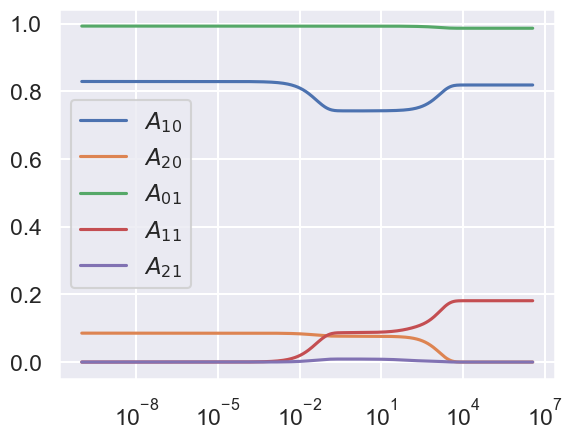

In [1083]:
plt.plot(t, A10/rtot_synapse, label = r'$A_{10}$')
plt.plot(t, A20/rtot_synapse, label = r'$A_{20}$')
plt.plot(t, A01/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(t, A11/rtot_synapse, label = r'$A_{11}$')
plt.plot(t, A21/rtot_synapse, label = r'$A_{21}$')
print(A11[-1] + A21[-1])


plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [1084]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-11, 1e-4, 75)
rtots = [1e4, 1e5, 1e6]

A10rs = np.zeros((len(rtots), len(A0s)))
A20rs = np.zeros((len(rtots), len(A0s)))
A01rs = np.zeros((len(rtots), len(A0s)))
A11rs = np.zeros((len(rtots), len(A0s)))
A21rs = np.zeros((len(rtots), len(A0s)))

for j, rtot in enumerate(rtots):
    """
    D_t = 1e-14
    D_f = 7.4e-14
    kon=1e5
    rtot_synapse = rtot*tumour_cell_IS_proportion
    rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(tumour_cell_surface_area)
    k4 = 4*D_f/(NK_cell_surface_area)   
    """

    target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)
    k2_single = target_effective_conc*kon   
    rtot_synapse = rtot*tumour_cell_IS_proportion


    target_effective_conc1 =(rtot_synapse)*(synapse_width**2)*(1/N_A)/(reaction_volume1)
    k2 = target_effective_conc1*kon


    target_effective_conc4 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
    k6 = target_effective_conc2*kon

    target_effective_conc5 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume_4)
    k7 = target_effective_conc5*kon
    
    for i, Ainit in enumerate(A0s):
        print(i)
        z0 = [0, 0]
        z = solve_ivp(R_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

        Atot_whole = well_size*N_A*Ainit/Target_cell_number
        A1 = z.y[0]
        A2 = z.y[1]

        Atot_NK = Atot_whole - A1[-1] - A2[-1]

        z = solve_ivp(NK_cell_model, tspan, [0], method='BDF', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK))

        A01 = z.y[0]

        A01_IC = A01[-1]*NK_cell_IS_proportion
        A10_IC = A1[-1]*tumour_cell_IS_proportion
        A20_IC = A2[-1]*tumour_cell_IS_proportion

        #Atot = A10_IC + A20_IC + A01_IC
        Atot = A10_IC + A20_IC 
        z0 = [A10_IC, A20_IC, 0, 0, 0]
    
        z = solve_ivp(R_two_cells, tspan, z0, method='BDF', t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
        print(z.message)
        A10 = z.y[0]
        A20 = z.y[1]
        A01 = z.y[2]
        A11 = z.y[3]
        A21 = z.y[4]

        A10rs[j][i] = A10[-1]
        A20rs[j][i] = A20[-1]
        A01rs[j][i] = A01[-1]
        A11rs[j][i] = A11[-1]
        A21rs[j][i] = A21[-1]

0


KeyboardInterrupt: 

In [ ]:
sns.set_theme()
sns.set_context('talk')
"""
plt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')
plt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')
plt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')
plt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()
"""

"\nplt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')\nplt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')\nplt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')\nplt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')\nplt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')\n\n\nplt.xscale('log')\nplt.legend(loc='best')\nplt.show()\n"

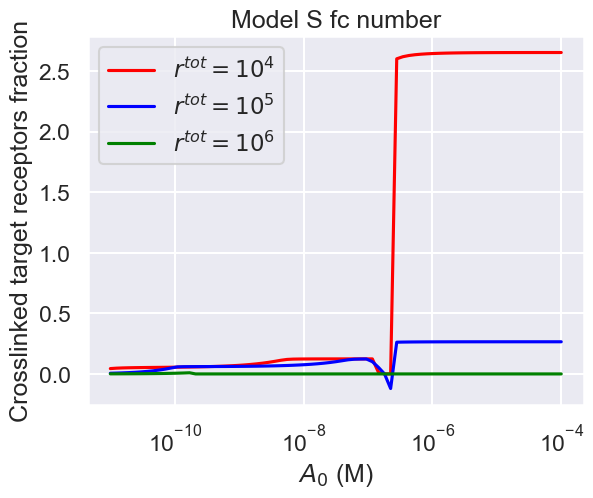

In [ ]:
labels = [r'$r^{tot} = 10^4$', r'$r^{tot} = 10^5$', r'$r^{tot} = 10^6$']
colors = ['red', 'blue', 'green']

for i, label in enumerate(labels):
    plt.plot(A0s, A11rs[i][:]/rtots[i] + A21rs[i][:]/rtots[i], label=label, c=colors[i])

plt.xscale('log')
plt.title('Model R fc number')
plt.legend(loc='best')
plt.xlabel(r'$A_0$ ' + '(M)')
plt.ylabel('Crosslinked target receptors fraction')
plt.show()